In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


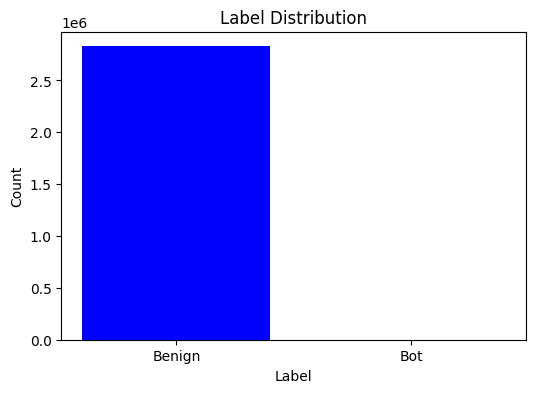

Class distribution in y_train before adjustment: (array([0, 1]), array([1386101,     963]))
Class distribution in y_val: (array([0, 1]), array([594043,    413]))
Class distribution in y_test: (array([0, 1]), array([848633,    590]))
Class distribution in y_train before SMOTE: (array([0, 1]), array([1386101,     963]))
Class distribution after SMOTE: (array([0, 1]), array([1386101, 1386101]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9446 - loss: 0.1509 - val_accuracy: 0.9875 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 2/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9849 - loss: 0.0530 - val_accuracy: 0.9876 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 3/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9914 - loss: 0.0499 - val_accuracy: 0.9881 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 4/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9917 - loss: 0.0487 - val_accuracy: 0.9883 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 5/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9919 - loss: 0.0479 - val_accuracy: 0.9879 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 6/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9919 - loss: 0.0479 - val_accuracy: 0.9880 - val_loss: 0.0448 - learning_rate: 0.0010
Epoch 7/50
10829/10829 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step -

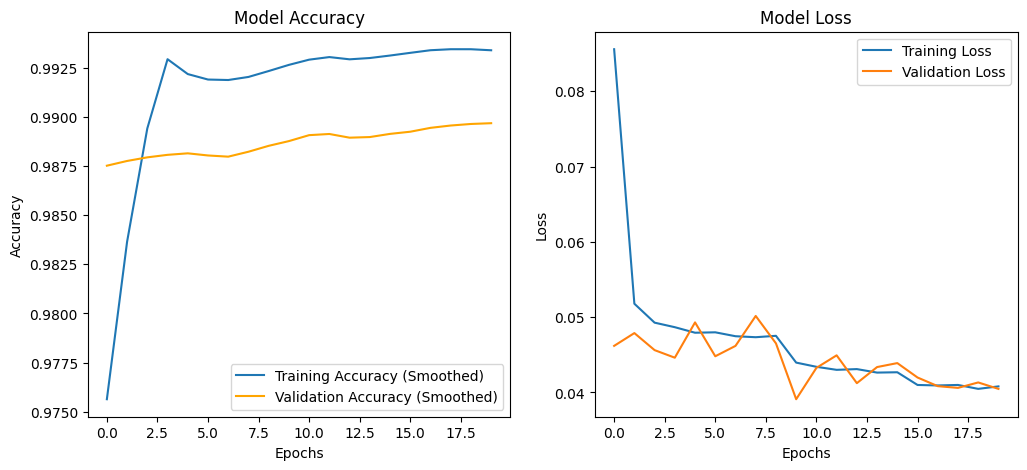

26539/26539 ━━━━━━━━━━━━━━━━━━━━ 27s 991us/step


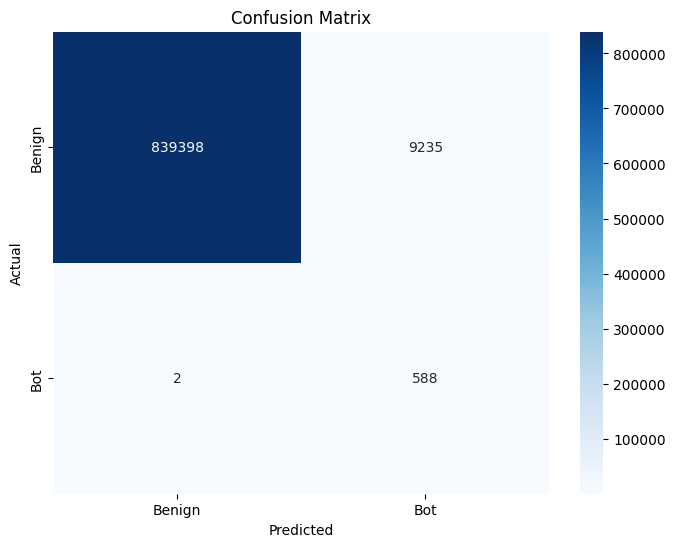

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    848633
           1       0.06      1.00      0.11       590

    accuracy                           0.99    849223
   macro avg       0.53      0.99      0.55    849223
weighted avg       1.00      0.99      0.99    849223



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

# Step 1: Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    label_column = ' Label'
    if label_column not in data.columns:
        raise KeyError(f"The specified label column '{label_column}' is missing in the dataset.")
    data[label_column] = data[label_column].apply(lambda x: 1 if x.strip() == 'Bot' else 0)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(data.mean(), inplace=True)
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data = data[numeric_cols]
    X = data.drop(columns=[label_column])
    y = data[label_column]
    return X, y

# Step 2: Plot label distribution
def plot_label_distribution(y):
    label_counts = y.value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
    plt.xticks(ticks=[0, 1], labels=["Benign", "Bot"])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Label Distribution")
    plt.show()

# Step 3: Split data into training, validation, and test sets
def split_data(X, y):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

    # Ensure both classes are present in training data
    print("Class distribution in y_train before adjustment:", np.unique(y_train, return_counts=True))
    if len(np.unique(y_train)) < 2:
        print("Warning: Only one class present in y_train. Adjusting...")
        minority_class = 1 if np.sum(y_train) == 0 else 0

        # Find indices of minority class samples in validation set
        minority_indices = np.where(y_val == minority_class)[0]
        if len(minority_indices) == 0:
            raise ValueError("The dataset is too imbalanced. No minority class samples available for augmentation.")

        # Add minority class samples from validation set to training set
        X_train = np.vstack([X_train, X_val.iloc[minority_indices]])
        y_train = np.hstack([y_train, y_val.iloc[minority_indices]])
        print("Adjusted class distribution in y_train:", np.unique(y_train, return_counts=True))

    print("Class distribution in y_val:", np.unique(y_val, return_counts=True))
    print("Class distribution in y_test:", np.unique(y_test, return_counts=True))

    return X_train, X_val, X_test, y_train, y_val, y_test

# Step 4: Balance the training data using SMOTE
def balance_training_data(X_train, y_train):
    if len(np.unique(y_train)) < 2:
        raise ValueError("SMOTE cannot be applied because only one class is present in the training data.")

    smote = SMOTE(random_state=42)
    print("Class distribution in y_train before SMOTE:", np.unique(y_train, return_counts=True))
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("Class distribution after SMOTE:", np.unique(y_train_smote, return_counts=True))
    return X_train_smote, y_train_smote

# Step 5: Build a Dense Neural Network model
def build_dense_nn_model(input_dim, dense_units=32, dropout_rate=0.5):  # Reduced model complexity
    model = Sequential()
    model.add(Dense(dense_units, activation='relu', input_dim=input_dim, kernel_regularizer=l2(1e-4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 6: Train the model
def train_model(model, X_train, y_train, X_val, y_val, class_weights):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Reduced to 50 epochs
        batch_size=256,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )
    return history

# Step 7: Smooth and plot training metrics
def smooth_curve(values, window_length=7, polyorder=2):
    return savgol_filter(values, window_length=window_length, polyorder=polyorder)

def plot_training_metrics(history):
    plt.figure(figsize=(12, 5))

    # Smooth accuracy
    smoothed_val_accuracy = smooth_curve(history.history['val_accuracy'])
    smoothed_train_accuracy = smooth_curve(history.history['accuracy'])

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(smoothed_train_accuracy, label='Training Accuracy (Smoothed)')
    plt.plot(smoothed_val_accuracy, label='Validation Accuracy (Smoothed)', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Step 8: Evaluate and plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Bot'], yticklabels=['Benign', 'Bot'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Main Script
if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/archive/merged_dst.csv'  # Change this to your dataset path
    X, y = load_and_preprocess_data(file_path)
    plot_label_distribution(y)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Balance the training data
    try:
        X_train, y_train = balance_training_data(X_train, y_train)
    except ValueError as e:
        print(f"Error during balancing: {e}")
        print("Ensure that the dataset has sufficient samples for both classes.")

    # Compute class weights
    if len(np.unique(y_train)) > 1:
        class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
        class_weights = dict(enumerate(class_weights))
    else:
        class_weights = None

    # Build and train the model
    model = build_dense_nn_model(input_dim=X_train.shape[1])
    history = train_model(model, X_train, y_train, X_val, y_val, class_weights)

    # Plot training metrics
    plot_training_metrics(history)

    # Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test)


CNN, LSTM Models


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load and preprocess data
file_path = '/content/drive/MyDrive/archive/merged_dst.csv'  # Change this to your dataset path
label_column = ' Label'

# Load data
data = pd.read_csv(file_path)
if label_column not in data.columns:
    raise KeyError(f"The specified label column '{label_column}' is missing in the dataset.")

# Encode labels (Benign: 0, Bot: 1)
data[label_column] = data[label_column].apply(lambda x: 1 if x.strip() == 'Bot' else 0)

# Handle missing values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Select numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data = data[numeric_cols]

# Split features and labels
X = data.drop(columns=[label_column])
y = data[label_column]

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

# Balance training data using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Print class distributions
print("Class distribution in y_train after SMOTE:", np.unique(y_train, return_counts=True))
print("Class distribution in y_val:", np.unique(y_val, return_counts=True))
print("Class distribution in y_test:", np.unique(y_test, return_counts=True))


Class distribution in y_train after SMOTE: (array([0, 1]), array([1386101, 1386101]))
Class distribution in y_val: (array([0, 1]), array([594043,    413]))
Class distribution in y_test: (array([0, 1]), array([848633,    590]))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reshape data for CNN input (add channel dimension)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# Build CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn_lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[cnn_early_stopping, cnn_lr_scheduler]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9816 - loss: 0.0629 - val_accuracy: 0.9850 - val_loss: 0.0464 - learning_rate: 0.0010
Epoch 2/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9919 - loss: 0.0329 - val_accuracy: 0.9847 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 3/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9933 - loss: 0.0266 - val_accuracy: 0.9871 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 4/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9952 - loss: 0.0190 - val_accuracy: 0.9875 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 5/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9957 - loss: 0.0179 - val_accuracy: 0.9947 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 6/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9963 - loss: 0.0158 - val_accuracy: 0.9923 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 7/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step -

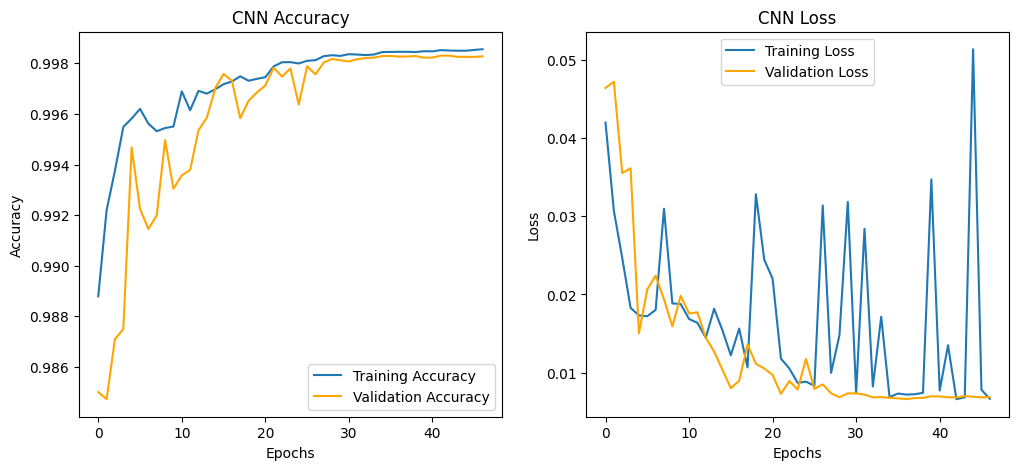

26539/26539 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    848633
           1       0.28      0.95      0.43       590

    accuracy                           1.00    849223
   macro avg       0.64      0.97      0.72    849223
weighted avg       1.00      1.00      1.00    849223



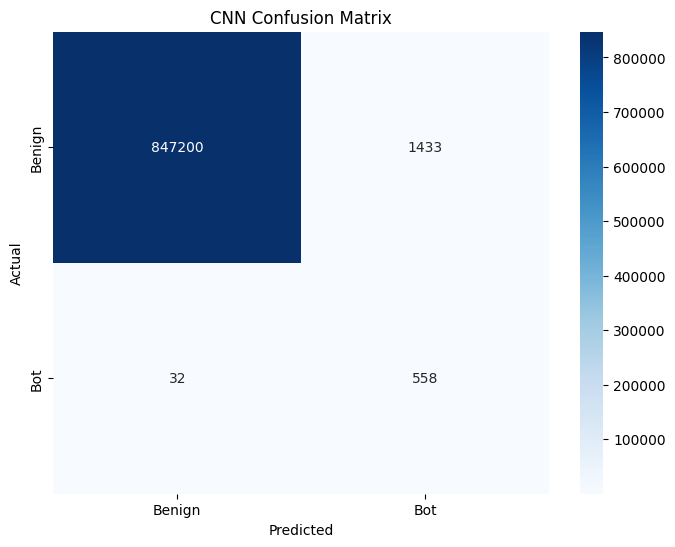

In [ ]:
def plot_training_metrics(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Bot'], yticklabels=['Benign', 'Bot'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# CNN Evaluation
plot_training_metrics(cnn_history, "CNN")
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 226s 10ms/step - accuracy: 0.6612 - loss: 30.9400 - val_accuracy: 0.9042 - val_loss: 0.2726 - learning_rate: 0.0010
Epoch 2/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 220s 10ms/step - accuracy: 0.9077 - loss: 0.2607 - val_accuracy: 0.9782 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 3/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 221s 10ms/step - accuracy: 0.8478 - loss: 515853.5625 - val_accuracy: 0.1726 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 4/50
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 221s 10ms/step - accuracy: 0.5397 - loss: 255820627968.0000 - val_accuracy: 0.2904 - val_loss: 11627272.0000 - learning_rate: 0.0010
Epoch 5/50
21657/21658 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5386 - loss: 33038012.0000
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21658/21658 ━━━━━━━━━━━━━━━━━━━━ 222s 10ms/step - accuracy: 0.5386 - loss: 33035846.0000 - val_accuracy: 0.7286 - val_loss: 15.4324 - learning_rate: 0.0010
Epoch 6/50

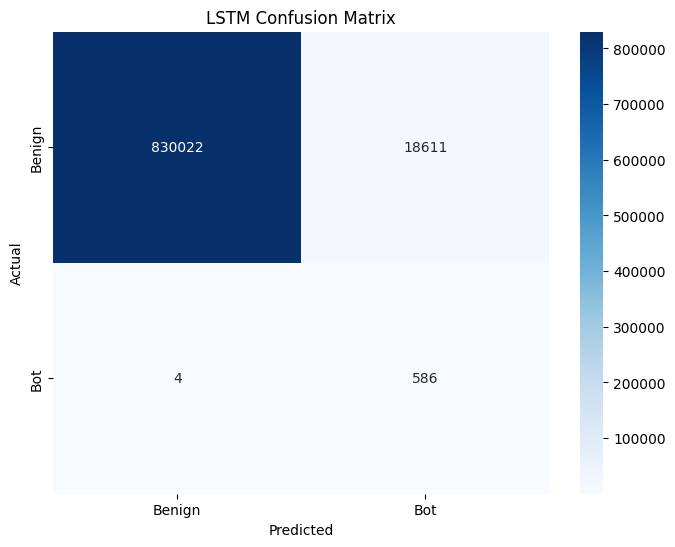

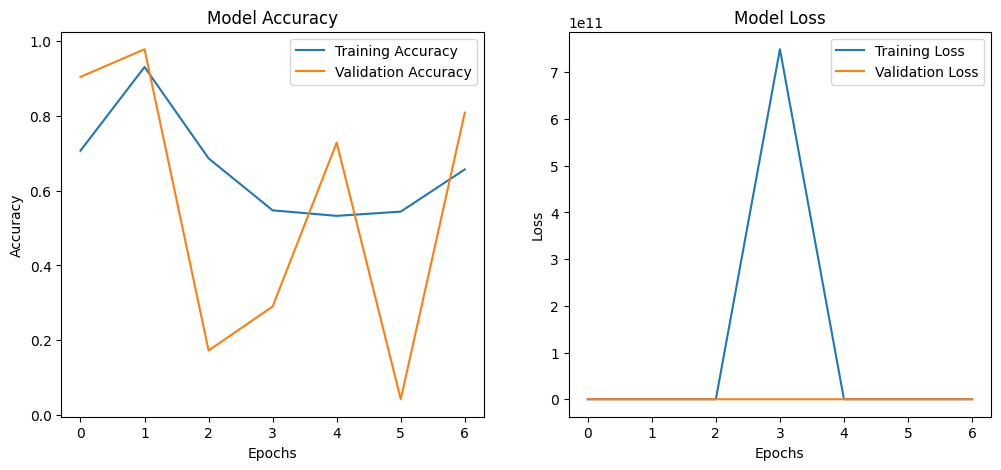

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Reshape data for LSTM input
X_train_lstm = X_train[..., np.newaxis]  # Add time dimension
X_val_lstm = X_val[..., np.newaxis]
X_test_lstm = X_test[..., np.newaxis]

# Build the LSTM model
lstm_model = Sequential([
    LSTM(32, activation='relu', return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)),  # Single LSTM layer
    Dropout(0.3),  # Moderate dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,  # Reduced epochs for faster convergence
    batch_size=128,  # Larger batch size for faster execution
    class_weight=class_weights,  # Handle imbalanced data
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate and plot results
def evaluate_lstm_model():
    y_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)

    # Classification report
    print("LSTM Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Bot'], yticklabels=['Benign', 'Bot'])
    plt.title("LSTM Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot accuracy and loss curves
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

evaluate_lstm_model()
